<i>Updated 19/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />

# Variational Auto Encoder Training for MNIST dataset with Tensorflow 2 on Google Colab

Train Variational Auto Encoder on MNIST dataset.
Variational Auto Encoder is a modification of the encoder and loss function for Auto Encoder.

## MNIST データセットに対して Variational Auto Encoder をGoogle Colab 上の Tensorflow 2 で学習する

MNIST データセットに対して変分オートエンコーダを学習させる。
Variational Auto Encoder とは、AutoEncoder に対して encoder と losss function (損失関数) に変更を加えたものである。

In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# About Encoder of VariationalAutoEncoder



With AutoEncoder, eath image is directly mapped to one point in the latent space.
With VariationalAutoEncoder, each image is mapped to a multivariate normal distribution around a point in latent space.

The covariance matrix is a diagonal matrix because VariationalAutoEncoder considers that there is no correlation between any dimensions of the latent space.
As a result, the encoder only needs to map each input to the mean vector and the variance vector, and does not have to worry about the correlation between the dimensions.
Furthermore, when mapped to the logarithm of the variance, any real number in the range($-\infty$, $\infty$) can be assigned.


## VariationalAutoEncoder の Encoder について

AutoEncoder では、各画像は潜在空間の1点に直接写像される。
VariationalAutoEncoder では、各画像は潜在空間のある点の周りの多変量正規分布に写像される。

変分オートエンコーダでは、潜在空間のどの次元間にも相関がないとみなすので、共分散行列は対角行列になる。 これにより、エンコーダは各入力を平均ベクトルと分散ベクトルに写像すればよく、次元間の相関を気にする必要はない。 さらに、分散の対数に写像すると  (−∞,∞)  の範囲のどのような実数でもとれる。

# Covariance Matrix

The variance-covariance matrix is a matrix obtained by extending the concept of variance (an index showing the degree of distribution) to multidimensional random varaible.

## Difinition for 2 random variables

For the random variables $X_1$ and $X_2$, the variance-covariance matrix is define as follows. 

$\Sigma = 
\left( \begin{array}{cc}
    \sigma_1^2 & \sigma_{12} \\
    \sigma_{12} & \sigma_2^2 \\
\end{array} \right )$

where <br />
$\sigma_1^2 = \mbox{variance of } X_1 $, <br />
$\sigma_2^2 = \mbox{variance of } X_2 $, <br />
$\sigma_{12} = \mbox{covariance of } X_1 \mbox{ and } X_2$ <br />

$\Sigma$ is called a variance-covariance matrix because the variances are lined up on the diagonal components and the covariances are lined up on the off-diagonal components.

It is defined in the same way when there are $n$ random variables.

For the random variables $X_1$, $\cdots$, $X_n$, An $n\times n$ matrix is called a variance-covariance matris where the $ii$ component is $\sigma_i^2$, and the $ij$ component ($i\neq j$) is $\sigma_{ij}$.

## Example: Find the variance and covariance of 5 data in 2 variables.

Suppose that $(x_i, y_i) = (4,5), (5, 7), (6,6), (7,9), (8,8)$ are given as data.

Mean of $x$ : $\mu_x = \displaystyle \frac{1}{5} (4+5+6+7+8)=6$,<br />
Mean of $y$ : $\mu_y = \displaystyle \frac{1}{5}(5 + 7+6+9+8)=7$<br />

Variance of $x$: <br />
$\sigma_x^2 = \displaystyle\frac{1}{5}\sum_{k=1}^5 (x_i - \mu_x)^2 \\
\quad = \displaystyle \frac{1}{5} ((4-6)^2+(5-6)^2+(6-6)^2 + (7-6)^2 +(8-6)^2 ) \\
\quad = \displaystyle \frac{1}{5} (2^2 + 1^2 + 0^2 + 1^2 + 2^2) = 2$ <br />
Variance of $y$<br />
$\sigma_y^2 = \displaystyle\frac{1}{5} \sum_{k=1}^{5} (y_i - \mu_y)^2 \\ 
\quad = \displaystyle{1}{5}((5-7)^2 +(7-7)^2 +(6-7)^2 +(9-7)^2 +(8-7)^2 ) \\
\quad = \displaystyle \frac{1}{5} (2^2 + 0^2 + 1^2 + 2^2 + 1^2) = 2$ <br />

Covariance of $x$ and $y$:<br />
$\sigma_{xy} = \displaystyle \frac{1}{5} \sum_{k=1}^5 (x_i - \mu_x) (y_i - \mu_y) \\ 
\quad = \displaystyle \frac{1}{5} ((4-6)(5-7)+(5-6)(7-7)+(6-6)(6-7)+(7-6)(9-7)+(8-6)(8-7)) \\
\quad = \displaystyle \frac{1}{5}((-2)(-2) + (-1)\cdot 0 + 0 \cdot (-1) + 1 \cdot 2 + 2 \cdot 1)=\frac{8}{5}=1.6
$

Variance and covariance matrix of $x$ and $y$:<br />
$\Sigma = \left(
\begin{array}{cc}
\sigma_x^2 & \sigma_{xy} \\ 
\sigma_{xy} & \sigma_y^2 \\
\end{array}
\right) =  \left(
\begin{array}{cc}
2 & 1.6 \\
1.6 & 2 \\
\end{array}
\right)$


## 分散共分散行列

分散共分散行列とは、分散(散らばり具合を表す指標)の概念を多次元確率変数に拡張して行列としたもの。単に共分散行列と呼ぶこともある。

### 確率変数が2つの場合の定義

確率変数 $X_1$, $X_2$ に対して、分散共分散行列 を
$\Sigma = 
\left( \begin{array}{cc}
    \sigma_1^2 & \sigma_{12} \\
    \sigma_{12} & \sigma_2^2 \\
\end{array} \right )$
と定義する。
ただし、<br />
$\sigma_1^2 = X_1 \mbox{の分散}$, <br />
$\sigma_2^2 = X_2 \mbox{の分散}$, <br />
$\sigma_{12} = X_1 \mbox{と} X_2 \mbox{の共分散}$ <br />
を表す。対角成分に分散が並び、非対角成分には共分散が並ぶため、分散共分散行列と呼ばれる。

確率変数が $n$ 個の場合も同様に定義される。

確率変数 $X_1$, $\cdots$, $X_n$ に対して、
第 $ii$ 成分が $\sigma_i^2$, <br />
第 $ij$ 成分 ($i \neq j$)が $\sigma_{ij}$ <br />
であるような $n\times n$行列 $\Sigma$ を
分散共分散行列と呼ぶ。

### 例題: 2変数の5個のデータの分散と共分散を求めよ。
データとして
$(x_i, y_i) = (4, 5), (5, 7), (6, 6), (7,9), (8, 8)$
が与えられたとする。

$x$の平均 
$\mu_x = \displaystyle\frac{1}{5} (4 + 5 + 6 + 7 + 8) = 6$, <br />
$y$ の平均
$\mu_y = \displaystyle\frac{1}{5} (5 + 7 + 6 + 9 + 8) = 7$ <br />

$x$ の分散は<br />
$\sigma_x^2 = \displaystyle\frac{1}{5}\sum_{k=1}^5 (x_i - \mu_x)^2 \\
\quad = \displaystyle \frac{1}{5} ((4-6)^2+(5-6)^2+(6-6)^2 + (7-6)^2 +(8-6)^2 ) \\
\quad = \displaystyle \frac{1}{5} (2^2 + 1^2 + 0^2 + 1^2 + 2^2) = 2$ <br />
$y$の分散は<br />
$\sigma_y^2 = \displaystyle\frac{1}{5} \sum_{k=1}^{5} (y_i - \mu_y)^2 \\ 
\quad = \displaystyle{1}{5}((5-7)^2 +(7-7)^2 +(6-7)^2 +(9-7)^2 +(8-7)^2 ) \\
\quad = \displaystyle \frac{1}{5} (2^2 + 0^2 + 1^2 + 2^2 + 1^2) = 2$ <br />

$x$ と $y$の共分散は<br />
$\sigma_{xy} = \displaystyle \frac{1}{5} \sum_{k=1}^5 (x_i - \mu_x) (y_i - \mu_y) \\ 
\quad = \displaystyle \frac{1}{5} ((4-6)(5-7)+(5-6)(7-7)+(6-6)(6-7)+(7-6)(9-7)+(8-6)(8-7)) \\
\quad = \displaystyle \frac{1}{5}((-2)(-2) + (-1)\cdot 0 + 0 \cdot (-1) + 1 \cdot 2 + 2 \cdot 1)=\frac{8}{5}=1.6
$

$x$ と $y$ の分散共分散行列は <br />
$\Sigma = \left(
\begin{array}{cc}
\sigma_x^2 & \sigma_{xy} \\ 
\sigma_{xy} & \sigma_y^2 \\
\end{array}
\right) =  \left(
\begin{array}{cc}
2 & 1.6 \\
1.6 & 2 \\
\end{array}
\right)$

# Normal Distribution

Probability density function of one-dimensional normal distribution <br />
$\displaystyle f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$<br />
where mean $\mu$, variance $\sigma^2$, standard deviation $\sigma$.

## 正規分布

平均(mean) $\mu$, 分散(variance) $\sigma^2$, 標準偏差(standard deviatioin) $\sigma$ として1次元の正規分布の確率密度関数 <br />
$\displaystyle f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

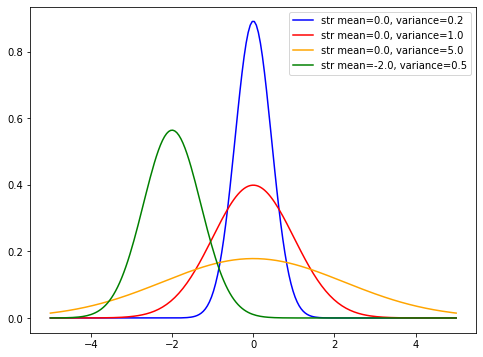

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5, 5, 200)

def f(x, m, v):
    d = x-m
    return np.exp(- d*d / (2.0 * v)) / np.sqrt(2 * np.pi * v)

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(x, f(x, 0.0, 0.2),label='str mean=0.0, variance=0.2',color='blue')
ax.plot(x, f(x, 0.0, 1.0),label='str mean=0.0, variance=1.0',color='red')
ax.plot(x, f(x, 0.0, 5.0),label='str mean=0.0, variance=5.0',color='orange')
ax.plot(x, f(x, -2.0, 0.5),label='str mean=-2.0, variance=0.5',color='green')

plt.legend()
plt.show()
    

# VariationalAutoEncoder

Sample the point $z$ as follows.

$ z = \mu + \sigma \epsilon$ <br />

$\mu$ represents where to place the marker, $\sigma$ is its certainty, and $\epsilon$ is a randomly selected value according to the probability distribution.
The point is tried to place around the $\mu$, so it is expected that the latent space will be continuous.

Since the relationship
$x = \displaystyle e^{\log x}$ holds, the following formula holds. <br />
$\sigma = \displaystyle e^{\log \sigma} =  \displaystyle e^{\frac{2 \log \sigma}{2}} = \displaystyle e^{\frac{\log \sigma^2}{2}}$

Therefore, using the calculated $\log$ of variance $\sigma^2$, calculate the following equation for each dimension.<br /> 
$\mbox{sigma} = \sigma = \mbox{exp(log_var/2)}$

The features of the new variational encoder are as follows.

<ul>
<li>Instead of connecting the <code>Flatten</code> layer directly to the layer in the latent space, connect it to the layers of <code>mu</code> and <code>log_var</code>.</li>
<li>The <code>Sampling</code> layer samples points in the latent space from the normal distribution defined by <code>mu</code> and <code>log_var</code>.</li>
<li>There are 3 types of encoder model outputs: <code>mu</code>, <code>log_var</code> and <code>z</code>.</li>
</ul>

## 変分オートエンコーダ

次の式を使って点 $z$ をサンプリングする。

$ z = \mu + \sigma \epsilon$ <br />

$\mu$ は目印をどこに置くか表し、$\sigma$ はその確信度、$\epsilon$ はどのぐらい離れておくかを確率分布に従ってランダムに選んだ値となる。
$\mu$ を目標としてその周囲に置こうとするので、
潜在空間が連続となることが期待される。

$x = \displaystyle e^{\log x}$ という関係が成り立つので 
$\sigma = \displaystyle e^{\log \sigma} =  \displaystyle e^{\frac{2 \log \sigma}{2}} = \displaystyle e^{\frac{\log \sigma^2}{2}}$
が言える。
したがって、
分散 $\sigma^2$ の $\log$ を計算したもの $\mbox{log_var} = \log \sigma^2$ を使って、
$\mbox{sigma} = \sigma = \mbox{exp(log_var/2)}$
を各次元について計算する。

新しい変分エンコーダの特徴は次の通り。

<ul>
<li>Flatten 層を直接潜在空間の層に接続するのではなく　mu と log_var の層に接続する。</li>
<li>
Sampling 層は、mu と　log_var で定義される正規分布から潜在空間内の点をサンプリングする。</li>
<li>
encoderのモデルの出力は mu, log_var, z の3種類となる。
</li>
</ul>

# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [4]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 22 06:48:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp
Basically, <code>gdown</code> from Google Drive. Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

## Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする
基本的に Google Drive から <code>gdown</code> してください。 Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [7]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1ZCihR7JkMOity4wCr66ZCp-3ZOlfwwo3'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/VariationalAutoEncoder.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1ZCihR7JkMOity4wCr66ZCp-3ZOlfwwo3
To: /content/nw/VariationalAutoEncoder.py
100% 18.7k/18.7k [00:00<00:00, 17.3MB/s]


In [8]:
! cat {nw_path}/VariationalAutoEncoder.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import datetime

class Sampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0., stddev=1.)
        return mu + tf.keras.backend.exp(log_var / 2) * epsilon


class VAEModel(tf.keras.models.Model):
    def __init__(self, encoder, decoder, r_loss_factor, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.r_loss_factor = r_loss_factor


    @tf.function
    def loss_fn(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.square(x - reconstruction), axis=[1,2,3]
        ) * self.r_loss_factor
        kl_loss = tf.reduce_sum(
   

# Preparing MNIST dataset

## MNIST データセットを用意する

In [9]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

print(tf.__version__)

2.7.0


In [10]:
# prepare data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test_raw.shape)
print(y_test_raw.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [11]:
x_train = x_train_raw.reshape(x_train_raw.shape+(1,)).astype('float32') / 255.0
x_test = x_test_raw.reshape(x_test_raw.shape+(1,)).astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


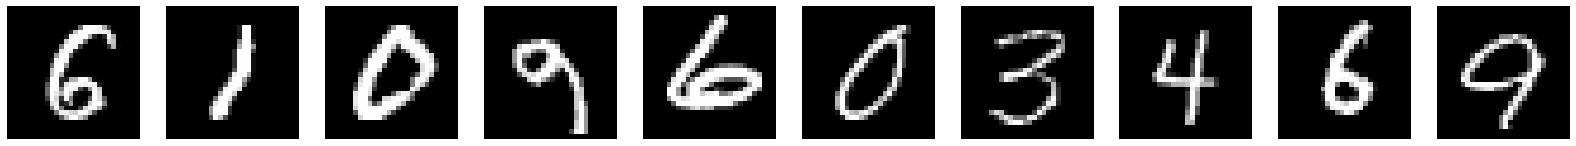

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = 10
selected_indices = np.random.choice(x_train_raw.shape[0], N)

fig, ax = plt.subplots(1, N, figsize=(2.8 * N, 2.8))
for i in range(N):
    ax[i].imshow(x_train_raw[selected_indices[i]],cmap='gray')
    ax[i].axis('off')

plt.show()

# Definition of Neural Network Model

Use the <code>VariationalAutoEndoer</code> class downloaded from nw.tsuda.ac.jp.

## ニューラルネットワーク・モデルを定義する

nw.tsuda.ac.jp からダウンロードした <code>VariationalAutoEncoder</code> クラスを使う。

In [13]:
from nw.VariationalAutoEncoder import VariationalAutoEncoder

vae = VariationalAutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2,
    r_loss_factor = 1000    
)

In [14]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 28, 28, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 14, 14, 64)   18496       ['leaky_re_lu[0][0]']            
                                                                                            

In [15]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                   

# Training

Train in 3 ways.


<font color="red">[Caution] 
Note that if you call the <code>save_image()</code> function in the Training (2), (3) below, <code>encoder.predict()</code> and <code>decoder.predict()</code> will work and the execution will be slow.</font>



## 学習する

3通りで学習する。


<font color="red">[注意] 
以下の学習 (2), (3) の途中で <code>save_images()</code>関数を呼び出すと、 <code>encoder.predict()</code>と <code>decoder.predict()</code> が動作して、実行が非常に遅くなるので注意すること。</font>

In [16]:
MAX_EPOCHS = 200

In [17]:
learning_rate = 0.0005

# (1) Training: Use <code>vae.model.fit()</code>

Note that the loss function is not specified at the call of <code>vae.model.compile()</code> function.
Since it cannot be calculated simply using <code>y_true</code> and <code>y_pred</code>, the <code>train_step()</code> function of the <code>VAEModel</code> class called from <code>fit()</code> is used to find loss and gradients and train them.
The <code>self.optimizer</code> of the <code>VAEModel</code> class referenced in the <code>train_step()</code> function is the optimizer given by the <code>compile()</code> function.


## (1) 学習する: <code>vae.model.fit()</code> を使う

<code>vae.model.compile()</code> 関数の呼び出しにおいて、loss関数を指定しないことに注意が必要である。
 <code>y_true</code> と <code>y_pred</code> を使って単純に計算できないので、<code>fit()</code> から呼び出される
 <code>VAEModel</code> クラスの
 <code>train_step()</code> 関数でlossとgradientsを求めて、trainingする。
 <code>train_step()</code> 関数の中で参照される <code>VAEModel</code> クラスの <code>self.optimizer</code> は <code>compile()</code> 関数で与えられた optimizer である。

In [18]:
import os
save_path1 = '/content/drive/MyDrive/ColabRun/VAE01'

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
vae.model.compile(optimizer=optimizer)

In [20]:
# まず、少ない回数 training してみる

history = vae.train_with_fit(
    x_train,
    batch_size = 32,
    epochs = 3,
    run_folder = save_path1
)

Epoch 1/3
1875/1875 [==============================] - 12s 5ms/step - loss: 58.4073 - reconstruction_loss: 55.1287 - kl_loss: 3.2786
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 51.5705 - reconstruction_loss: 47.5608 - kl_loss: 4.0097
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 50.0829 - reconstruction_loss: 45.7901 - kl_loss: 4.2928


In [21]:
print(history.history)

{'loss': [55.75687789916992, 51.232696533203125, 51.035667419433594], 'reconstruction_loss': [51.87708282470703, 46.880558013916016, 46.8510856628418], 'kl_loss': [3.879793643951416, 4.352138042449951, 4.184581756591797]}


In [22]:
print(history.history.keys())

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])


In [23]:
#tmp = history.history['loss']

#print(len(tmp))
#print(len(tmp[0]))

In [24]:
loss1_1 = history.history['loss']
rloss1_1 = history.history['reconstruction_loss']
kloss1_1 = history.history['kl_loss']

# Training in addition

Load the saved parameters and model weights, and try training further.

## 追加の学習

保存してあるパラメータと、モデルの重みを読み込んで、さらにtraining してみる。

In [25]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

vae_work = VariationalAutoEncoder.load(save_path1)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(vae_work.epoch)


3


In [26]:
# Training in addition
# 追加で training する。

vae_work.model.compile(optimizer)

history2 = vae_work.train_with_fit(
    x_train,
    batch_size = 32,
    epochs = MAX_EPOCHS,
    run_folder = save_path1
)

Epoch 4/200
1875/1875 [==============================] - 10s 5ms/step - loss: 49.8648 - reconstruction_loss: 45.5221 - kl_loss: 4.3427
Epoch 5/200
1875/1875 [==============================] - 10s 5ms/step - loss: 48.5465 - reconstruction_loss: 43.9828 - kl_loss: 4.5637
Epoch 6/200
1875/1875 [==============================] - 10s 5ms/step - loss: 48.0179 - reconstruction_loss: 43.3728 - kl_loss: 4.6451
Epoch 7/200
1875/1875 [==============================] - 10s 5ms/step - loss: 47.6538 - reconstruction_loss: 42.9425 - kl_loss: 4.7113
Epoch 8/200
1875/1875 [==============================] - 9s 5ms/step - loss: 47.3654 - reconstruction_loss: 42.6093 - kl_loss: 4.7561
Epoch 9/200
1875/1875 [==============================] - 9s 5ms/step - loss: 47.0985 - reconstruction_loss: 42.2911 - kl_loss: 4.8074
Epoch 10/200
1875/1875 [==============================] - 10s 5ms/step - loss: 46.9123 - reconstruction_loss: 42.0577 - kl_loss: 4.8546
Epoch 11/200
1875/1875 [==============================] 

In [27]:
print(len(history2.history))

3


In [28]:
loss1_2 = history2.history['loss']
rloss1_2 = history2.history['reconstruction_loss']
kloss1_2 = history2.history['kl_loss']

loss1 = np.concatenate([loss1_1, loss1_2], axis=0)
rloss1 = np.concatenate([rloss1_1, rloss1_2], axis=0)
kloss1 = np.concatenate([kloss1_1, kloss1_2], axis=0)

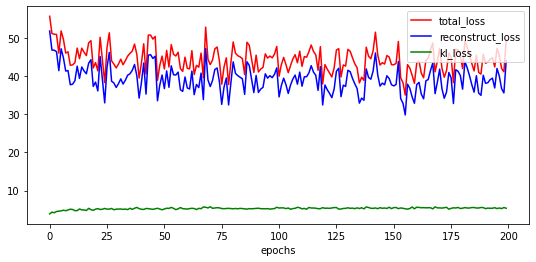

In [29]:
VariationalAutoEncoder.plot_history([loss1, rloss1, kloss1], ['total_loss', 'reconstruct_loss', 'kl_loss'])

# Validate Training results

Since the returned value of <code>vae.decoder()</code> is Tensor for the use of <code>@tf.function</code>, it needs to be converted to an array of numpy.

## 学習結果を検証する

@tf.function 宣言のため<code>vae.decoder()</code> の返り値は Tensor になっているので、numpy の配列に変換する必要がある。 

In [30]:
selected_indices = np.random.choice(range(len(x_test)), 10)
selected_images = x_test[selected_indices]

In [31]:
z_mean, z_log_var, z = vae_work.encoder(selected_images)
reconst_images = vae_work.decoder(z).numpy()  # Convert Tensor to numpy array.

txts = [f'{p[0]:.3f}, {p[1]:.3f}' for p in z ]

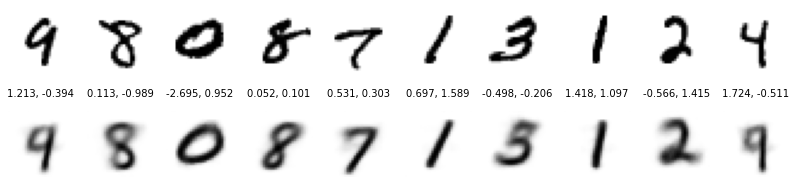

In [32]:
%matplotlib inline

VariationalAutoEncoder.showImages(selected_images, reconst_images, txts, 1.4, 1.4)

# (2) Training with <code>tf.GradientTape()</code> function.
Instead of using <code>fit()</code>, calculate the loss in your own <code>train()</code> function, find the gradients, and apply them to the variables.

The <code>train_tf()</code> function is speeding up by declaring <code>@tf.function</code> the <code>compute_loss_and_grads()</code> function.

## (2) <code>tf.GradientTape()</code> 関数を使った学習

<code>fit()</code> 関数を使わずに、自分で記述した <code>train()</code> 関数内で loss を計算し、gradients を求めて、変数に適用する。

<code>train_tf()</code> 関数では、lossとgradientsの計算を行う <code>compute_loss_and_grads()</code> 関数を <code>@tf.function</code> 宣言することで高速化を図っている。


In [33]:
save_path2 = '/content/drive/MyDrive/ColabRun/VAE02/'

In [34]:
from nw.VariationalAutoEncoder import VariationalAutoEncoder

vae2 = VariationalAutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2,
    r_loss_factor = 1000 
)

In [35]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [36]:
log2_1 = vae2.train_tf(
    x_train,
    batch_size = 32,
    epochs = 3,
    shuffle=True,
    run_folder = save_path2,
    optimizer = optimizer2,
    save_epoch_interval=50,
    validation_data=x_test
)

1/3 1875 loss: total 58.770 reconstruction 55.546 kl 3.224 val loss total 52.817 reconstruction 49.169 kl 3.648 0:00:18.577035
2/3 1875 loss: total 51.869 reconstruction 47.964 kl 3.905 val loss total 50.912 reconstruction 46.834 kl 4.078 0:00:35.127926
3/3 1875 loss: total 50.510 reconstruction 46.300 kl 4.210 val loss total 49.969 reconstruction 45.687 kl 4.282 0:00:51.720397


In [37]:
print(log2_1.keys())

loss2_1 = log2_1['loss']
rloss2_1 = log2_1['reconstruction_loss']
kloss2_1 = log2_1['kl_loss']
val_loss2_1 = log2_1['val_loss']
val_rloss2_1 = log2_1['val_reconstruction_loss']
val_kloss2_1 = log2_1['val_kl_loss']

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reconstruction_loss', 'val_kl_loss'])


In [38]:
# Load the saved parameters and weights.
# 保存したパラメータと重みを読み込む

vae2_work = VariationalAutoEncoder.load(save_path2)
print(vae2_work.epoch)

3


In [39]:
# Train in addition
# 追加で training する。

log2_2 = vae2_work.train_tf(
    x_train,
    batch_size = 32,
    epochs = MAX_EPOCHS,
    shuffle=True,
    run_folder = save_path2,
    optimizer = optimizer2,
    save_epoch_interval=50,
    validation_data=x_test
)


4/200 1875 loss: total 50.162 reconstruction 45.848 kl 4.314 val loss total 49.152 reconstruction 44.580 kl 4.572 0:00:17.277455
5/200 1875 loss: total 48.757 reconstruction 44.223 kl 4.534 val loss total 48.424 reconstruction 43.738 kl 4.686 0:00:33.858980
6/200 1875 loss: total 48.176 reconstruction 43.538 kl 4.638 val loss total 48.115 reconstruction 43.766 kl 4.349 0:00:50.429768
7/200 1875 loss: total 47.757 reconstruction 43.043 kl 4.714 val loss total 47.459 reconstruction 42.677 kl 4.781 0:01:06.866417
8/200 1875 loss: total 47.441 reconstruction 42.676 kl 4.765 val loss total 47.894 reconstruction 42.884 kl 5.011 0:01:23.446778
9/200 1875 loss: total 47.179 reconstruction 42.367 kl 4.813 val loss total 47.031 reconstruction 42.219 kl 4.812 0:01:40.115804
10/200 1875 loss: total 46.942 reconstruction 42.089 kl 4.853 val loss total 46.790 reconstruction 42.095 kl 4.695 0:01:56.976094
11/200 1875 loss: total 46.754 reconstruction 41.864 kl 4.890 val loss total 46.903 reconstructi

In [40]:
loss2_2 = log2_2['loss']
rloss2_2 = log2_2['reconstruction_loss']
kloss2_2 = log2_2['kl_loss']
val_loss2_2 = log2_2['val_loss']
val_rloss2_2 = log2_2['val_reconstruction_loss']
val_kloss2_2 = log2_2['val_kl_loss']

In [41]:
loss2 = np.concatenate([loss2_1, loss2_2], axis=0)
rloss2 = np.concatenate([rloss2_1, rloss2_2], axis=0)
kloss2 = np.concatenate([kloss2_1, kloss2_2], axis=0)

val_loss2 = np.concatenate([val_loss2_1, val_loss2_2], axis=0)
val_rloss2 = np.concatenate([val_rloss2_1, val_rloss2_2], axis=0)
val_kloss2 = np.concatenate([val_kloss2_1, val_kloss2_2], axis=0)

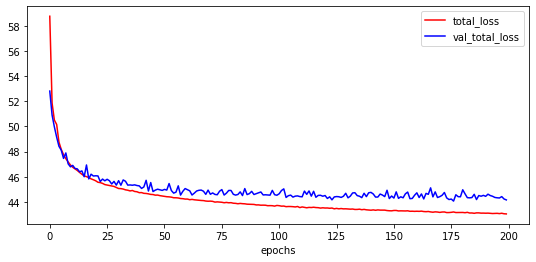

In [42]:
VariationalAutoEncoder.plot_history(
    [loss2, val_loss2], 
    ['total_loss', 'val_total_loss']
)

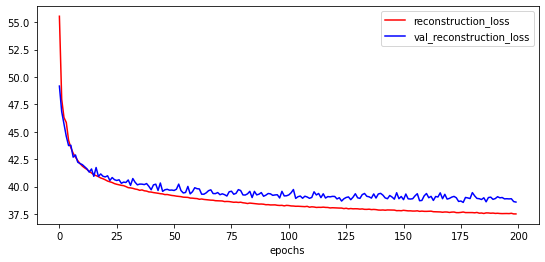

In [43]:
VariationalAutoEncoder.plot_history(
    [rloss2, val_rloss2], 
    ['reconstruction_loss', 'val_reconstruction_loss']
)

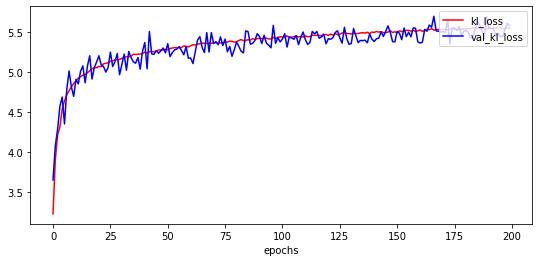

In [44]:
VariationalAutoEncoder.plot_history(
    [kloss2, val_kloss2], 
    ['kl_loss', 'val_kl_loss']
)

In [45]:
z_mean2, z_log_var2, z2 = vae2_work.encoder(selected_images)
reconst_images2 = vae2_work.decoder(z2).numpy()  # @tf.function 宣言のためdecoder() の返り値はTensorになっているのでnumpyの配列に変換する

txts2 = [f'{p[0]:.3f}, {p[1]:.3f}' for p in z2 ]

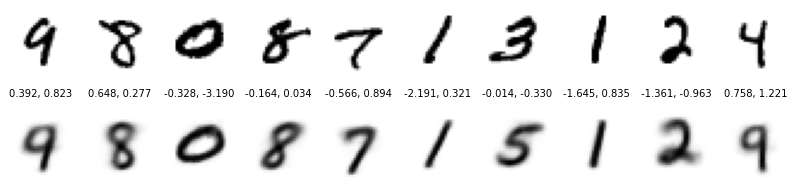

In [46]:
%matplotlib inline

VariationalAutoEncoder.showImages(selected_images, reconst_images2, txts2, 1.4, 1.4)

# (3) Trainig with <code>tf.GradientTape()</code> function and Learning rate decay

Calculate the loss and gradients with the <code>tf.GradientTape()</code> function, and apply the gradients to the variables. 
In addition, perform Learning rate decay in the optimizer.



## (3) <code>tf.GradientTape()</code> 関数と学習率減数を使った学習

<code>tf.GradientTape()</code> 関数を使って loss と gradients を計算して、gradients を変数に適用する。
さらに、optimizer において Learning rate decay を行う。



In [47]:
save_path3 = '/content/drive/MyDrive/ColabRun/VAE03/'

In [48]:
from nw.VariationalAutoEncoder import VariationalAutoEncoder

vae3 = VariationalAutoEncoder(
    input_dim = (28, 28, 1),
    encoder_conv_filters = [32, 64, 64, 64],
    encoder_conv_kernel_size = [3, 3, 3, 3],
    encoder_conv_strides = [1, 2, 2, 1],
    decoder_conv_t_filters = [64, 64, 32, 1],
    decoder_conv_t_kernel_size = [3, 3, 3, 3],
    decoder_conv_t_strides = [1, 2, 2, 1],
    z_dim = 2,
    r_loss_factor = 1000 
)

In [49]:
# initial_learning_rate * decay_rate ^ (step // decay_steps)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = 1000,
    decay_rate=0.96
)

optimizer3 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [50]:
log3_1 = vae3.train_tf(
    x_train,
    batch_size = 32,
    epochs = 3,
    shuffle=True,
    run_folder = save_path3,
    optimizer = optimizer3,
    save_epoch_interval=50,
    validation_data=x_test
)

1/3 1875 loss: total 58.493 reconstruction 55.239 kl 3.254 val loss total 53.440 reconstruction 49.923 kl 3.517 0:00:17.739827
2/3 1875 loss: total 51.609 reconstruction 47.612 kl 3.997 val loss total 50.649 reconstruction 46.397 kl 4.252 0:00:34.873874
3/3 1875 loss: total 50.013 reconstruction 45.694 kl 4.319 val loss total 49.614 reconstruction 44.967 kl 4.647 0:00:52.016673


In [51]:
print(log3_1.keys())

loss3_1 = log3_1['loss']
rloss3_1 = log3_1['reconstruction_loss']
kloss3_1 = log3_1['kl_loss']
val_loss3_1 = log3_1['val_loss']
val_rloss3_1 = log3_1['val_reconstruction_loss']
val_kloss3_1 = log3_1['val_kl_loss']

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reconstruction_loss', 'val_kl_loss'])


In [52]:
# 保存したパラメータと重みを読み込む

vae3_work = VariationalAutoEncoder.load(save_path3)
print(vae3_work.epoch)

3


In [53]:
# 追加で training する。
log3_2 = vae3_work.train_tf(
    x_train,
    batch_size = 32,
    epochs = MAX_EPOCHS,
    shuffle=True,
    run_folder = save_path3,
    optimizer = optimizer3,
    save_epoch_interval=50,
    validation_data=x_test
)


4/200 1875 loss: total 49.658 reconstruction 45.263 kl 4.395 val loss total 48.749 reconstruction 44.186 kl 4.563 0:00:17.616743
5/200 1875 loss: total 48.326 reconstruction 43.730 kl 4.596 val loss total 47.960 reconstruction 43.345 kl 4.614 0:00:34.516737
6/200 1875 loss: total 47.774 reconstruction 43.062 kl 4.713 val loss total 47.793 reconstruction 42.888 kl 4.905 0:00:51.485786
7/200 1875 loss: total 47.366 reconstruction 42.606 kl 4.760 val loss total 47.576 reconstruction 42.752 kl 4.824 0:01:08.380952
8/200 1875 loss: total 47.046 reconstruction 42.229 kl 4.817 val loss total 46.938 reconstruction 42.214 kl 4.724 0:01:25.407395
9/200 1875 loss: total 46.772 reconstruction 41.907 kl 4.865 val loss total 46.838 reconstruction 41.859 kl 4.979 0:01:42.374036
10/200 1875 loss: total 46.537 reconstruction 41.651 kl 4.886 val loss total 46.596 reconstruction 41.741 kl 4.855 0:01:59.453270
11/200 1875 loss: total 46.334 reconstruction 41.412 kl 4.922 val loss total 46.542 reconstructi

In [54]:
loss3_2 = log3_2['loss']
rloss3_2 = log3_2['reconstruction_loss']
kloss3_2 = log3_2['kl_loss']
val_loss3_2 = log3_2['val_loss']
val_rloss3_2 = log3_2['val_reconstruction_loss']
val_kloss3_2 = log3_2['val_kl_loss']

In [55]:
loss3 = np.concatenate([loss3_1, loss3_2], axis=0)
rloss3 = np.concatenate([rloss3_1, rloss3_2], axis=0)
kloss3 = np.concatenate([kloss3_1, kloss3_2], axis=0)

val_loss3 = np.concatenate([val_loss3_1, val_loss3_2], axis=0)
val_rloss3 = np.concatenate([val_rloss3_1, val_rloss3_2], axis=0)
val_kloss3 = np.concatenate([val_kloss3_1, val_kloss3_2], axis=0)

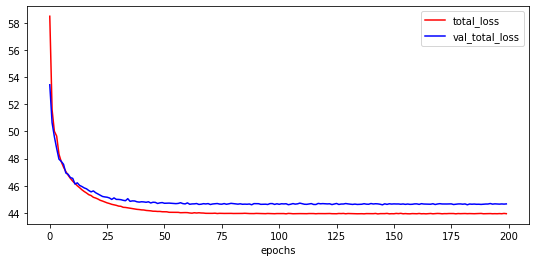

In [56]:
VariationalAutoEncoder.plot_history(
    [loss3, val_loss3], 
    ['total_loss', 'val_total_loss']
)

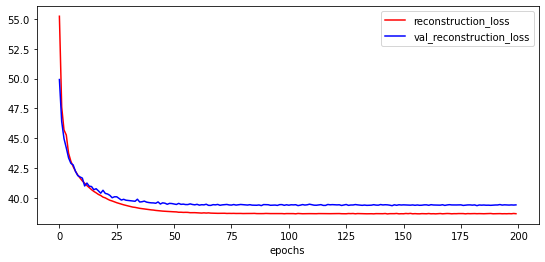

In [57]:
VariationalAutoEncoder.plot_history(
    [rloss3, val_rloss3], 
    ['reconstruction_loss', 'val_reconstruction_loss']
)

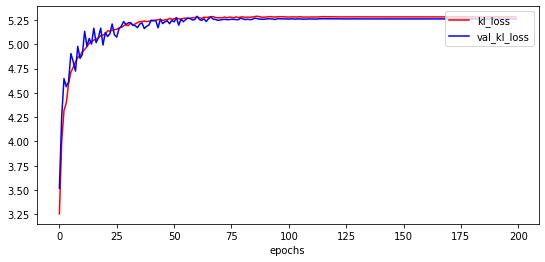

In [58]:
VariationalAutoEncoder.plot_history(
    [kloss3, val_kloss3], 
    ['kl_loss', 'val_kl_loss']
)

In [59]:
z_mean3, z_log_var3, z3 = vae3_work.encoder(selected_images)
reconst_images3 = vae3_work.decoder(z3).numpy()  # @tf.function 宣言のためdecoder() の返り値はTensorになっているのでnumpyの配列に変換する

txts3 = [f'{p[0]:.3f}, {p[1]:.3f}' for p in z3 ]

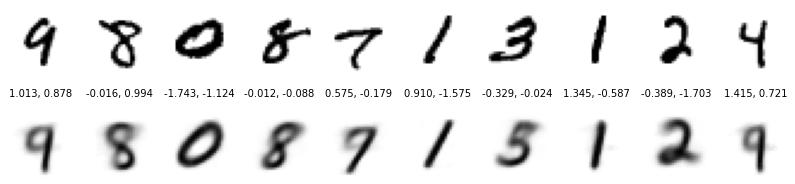

In [60]:
%matplotlib inline

VariationalAutoEncoder.showImages(selected_images, reconst_images3, txts3, 1.4, 1.4)